In [4]:
import pandas as pd
import numpy as np

In [5]:
# 透過 gdrive/My Drive/... 來存取檔案

X_train = pd.read_csv('./X_train.csv')
y = pd.read_csv('./y_train.csv')

X_test = pd.read_csv('./X_test.csv')
print(X_train.shape)
print(X_train.columns)
print(y.columns)

(85751, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

## Preprocess
  - Standarize X data
  - turn y_train into np array
  

In [7]:
sc = StandardScaler()
sc.fit(X_train)
X_std = sc.transform(X_train)
y = np.array(y)
y = y.reshape(y.shape[0])

## RandomForest
  - I tried with different hyper-parameter. ex. n_estimators, max_depth, and the best accuracy was 0.61.
  - I also used importances vector to select dominant features. Althogh the  two most dominant features are "SHOT_DIST" and "PTS_TYPE", I think "SHOT_DIST" actually contains the imformation of "PTS_TYPE since three-pointers are always longer than two-pointers in distance. So I finally choose "SHOT_DIST", "CLOSE_DEF_DISTANCE" and "SHOT_CLOCK" as my top-3 features.  

In [8]:

x_train, x_valid, y_train, y_valid = train_test_split(
        X_train, y, test_size=0.3, random_state=0)


forest = RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=1, n_jobs=2, max_depth=5)
forest.fit(x_train, y_train)
y_train_pred = forest.predict(x_train)
y_valid_pred = forest.predict(x_valid)
print('accuracy train: %.3f, valid: %.3f' % (
                accuracy_score(y_train, y_train_pred),
                accuracy_score(y_valid, y_valid_pred)))
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, X_train.columns.values[indices[f]], importances[indices[f]]))

accuracy train: 0.621, valid: 0.612
 1) SHOT_DIST                      0.492873
 2) PTS_TYPE                       0.122547
 3) CLOSE_DEF_DIST                 0.120860
 4) SHOT_CLOCK                     0.113474
 5) TOUCH_TIME                     0.098850
 6) DRIBBLES                       0.033844
 7) GAME_CLOCK                     0.012410
 8) PERIOD                         0.005141


## LASSO
  - I also use LASSO model to do feature selection, and the result are consistent with the above result.

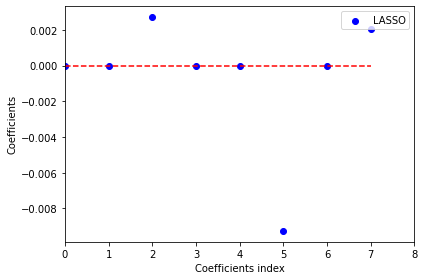

Selected attributes: ['SHOT_CLOCK' 'SHOT_DIST' 'CLOSE_DEF_DIST']


In [9]:
var_num = X_train.shape[1]

lr_lasso = Lasso(alpha = 0.1)
lr_lasso.fit(X_train, y)

plt.scatter(range(var_num),lr_lasso.coef_, label = 'LASSO', color = 'blue')
plt.hlines(y=0, xmin=0, xmax=var_num-1, color='red', linestyle ='--')
plt.xlim(0,8)
plt.legend(loc = 'upper right')
plt.xlabel('Coefficients index')
plt.ylabel('Coefficients')
plt.tight_layout()
plt.show()

epsilon = 1e-4
idxs = np.where(abs(lr_lasso.coef_) > epsilon)
print('Selected attributes: {}'.format(X_train.columns.values[idxs]))

## RidgeClassifier
  - This model is better than RandomForest. Althogh the best accuracy is also 0.61, it is simpler than RandomForest. So it is the best model by Occam's razor.
  - By plotting the error curve of this model, I choose degree 2 since the error of validation set is the lowest. We can see with degree larger than 2, the model start to overfit on trianing set data.
  - I also tried to use Ransac to detect outliers, but it seems useless to improving classification accuracy. So I decide not to include it in my best model.


[Degree = 1]
accuracy train: 0.608, valid: 0.610
[Degree = 2]
accuracy train: 0.618, valid: 0.615
[Degree = 3]
accuracy train: 0.619, valid: 0.614
[Degree = 4]
accuracy train: 0.621, valid: 0.611
[Degree = 5]
accuracy train: 0.628, valid: 0.608


/home/haowei/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.10828e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[Degree = 6]
accuracy train: 0.639, valid: 0.601


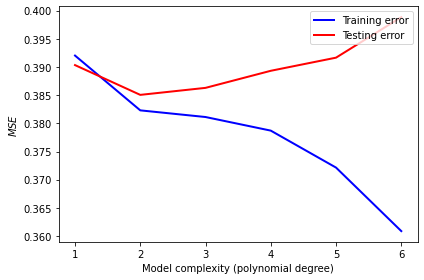

In [10]:
mse_train = []
mse_test = []
max_degree = 7
for d in range(1, max_degree):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X_std)
    
    x_train, x_valid, y_train, y_valid = train_test_split(
        X_poly, y, test_size=0.3, random_state=0)

    rg = RidgeClassifier(alpha=1.0)
    rg.fit(x_train, y_train)
    
    y_train_pred = rg.predict(x_train)
    y_valid_pred = rg.predict(x_valid)
    
    print('[Degree = %d]' % d)
    print('accuracy train: %.3f, valid: %.3f' % (
                    accuracy_score(y_train, y_train_pred),
                    accuracy_score(y_valid, y_valid_pred)))
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_valid, y_valid_pred))
    

plt.plot(range(1, max_degree), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, max_degree), mse_test, label = 'Testing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.show()

## TOP-3 features
  - Using my best model with only TOP-3 features.
  - We can see that the accuracy is only slightly worse than using all features. 

In [11]:
X_train_3 = X_train[['CLOSE_DEF_DIST', 'SHOT_CLOCK', 'SHOT_DIST']]
sc.fit(X_train_3)
X_std_3 = sc.transform(X_train_3)

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_std_3)

x_train, x_valid, y_train, y_valid = train_test_split(
    X_poly, y, test_size=0.3, random_state=0)


rg = RidgeClassifier(alpha=1.0)
rg.fit(x_train, y_train)

y_train_pred = rg.predict(x_train)
y_valid_pred = rg.predict(x_valid)

print('accuracy train: %.3f, valid: %.3f' % (
                accuracy_score(y_train, y_train_pred),
                accuracy_score(y_valid, y_valid_pred)))

accuracy train: 0.614, valid: 0.612


## Output
  - using the whole X_train, y_train as training set.
  - output y_pred.csv.

In [13]:
sc.fit(X_train)
X_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_std)
X_test_poly = poly.fit_transform(X_test_std)

rg = RidgeClassifier(alpha=1.0)
rg.fit(X_poly, y)

y_test_pred = rg.predict(X_test_poly)
df = pd.DataFrame(y_test_pred, columns=['FGM'])
df.to_csv(r'y_pred_yuang.csv', index = False, header=True)